In [131]:
from vrae.vrae import VRAE
from vrae.utils import *
from vrae.utils_EMG import *
import numpy as np
import torch
import pickle

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error as mse

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from seaborn import clustermap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dload = './model_dir'

In [24]:
seq_len = 10
hidden_size = 256
hidden_layer_depth = 3
latent_length = 16
batch_size = 32
learning_rate = 0.00002
n_epochs = 1500
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=10
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU
output = False

In [25]:
all_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                 '20201020_Pop_Cage_005','20201020_Pop_Cage_006','20201020_Pop_Cage_007']
X_all, y_all = load_data(direc = 'data', dataset="EMG", all_file = all_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
all_dataset = TensorDataset(torch.from_numpy(X_all))

Loading 20201020_Pop_Cage_001, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_002, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_003, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_004, X shape (3601, 150, 1), y shape (3601, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_005, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  5.]
Loading 20201020_Pop_Cage_006, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_007, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Dataset shape: (25184, 10, 15)
Label: [-1.  0.  1.  2.  3.  4.  5.], shape: (25184, 1)


In [26]:
num_features = X_all.shape[2]

In [27]:
from vrae.vrae import VRAE
vrae = VRAE(sequence_length=seq_len,
            number_of_features = num_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload,
            output = output)

/home/roton2/miniconda3/envs/emg/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [28]:
vrae.load(dload+'/vrae_b32_z16.pth')

In [29]:
z_run = vrae.transform(all_dataset)

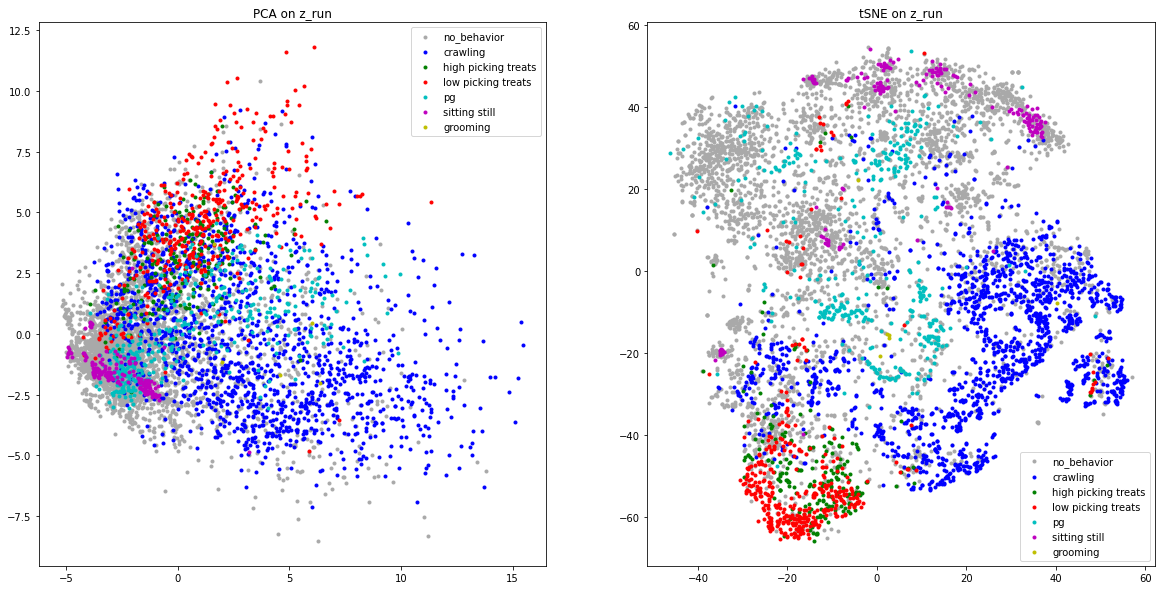

In [30]:
bhvs = {'no_behavior': np.array([-1]), 
        'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5])}

inv_bhvs = {int(v): k for k, v in bhvs.items()}

visualize(z_run = z_run, y = y_all, inv_bhvs = inv_bhvs, one_in = 4)

In [126]:
gm = GaussianMixture(n_components=100, random_state=111, max_iter=1000).fit_predict(z_run)
gmm_labels = np.reshape(gm, (gm.shape[0], 1))

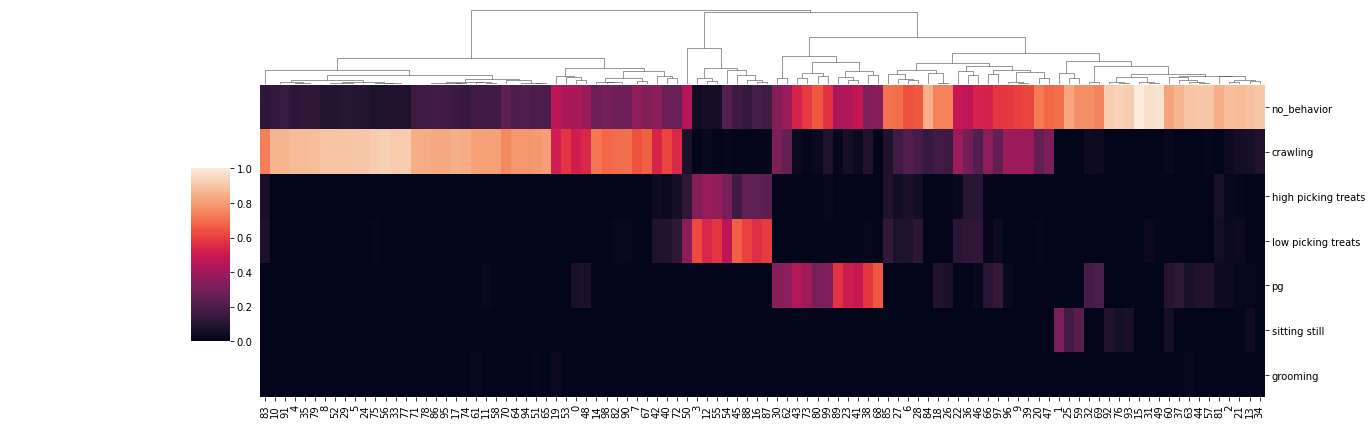

In [127]:
plot_confusion_matrix(y_all, gmm_labels, bhvs.keys(), figsize = (18,6))

In [40]:
hex_colors = []
for _ in np.unique(gm):
    hex_colors.append('#%06X' % randint(0, 0xFFFFFF))
# color2 =  ["blue","black","brown","red","yellow","green","orange","dimgray","turquoise","pink"]

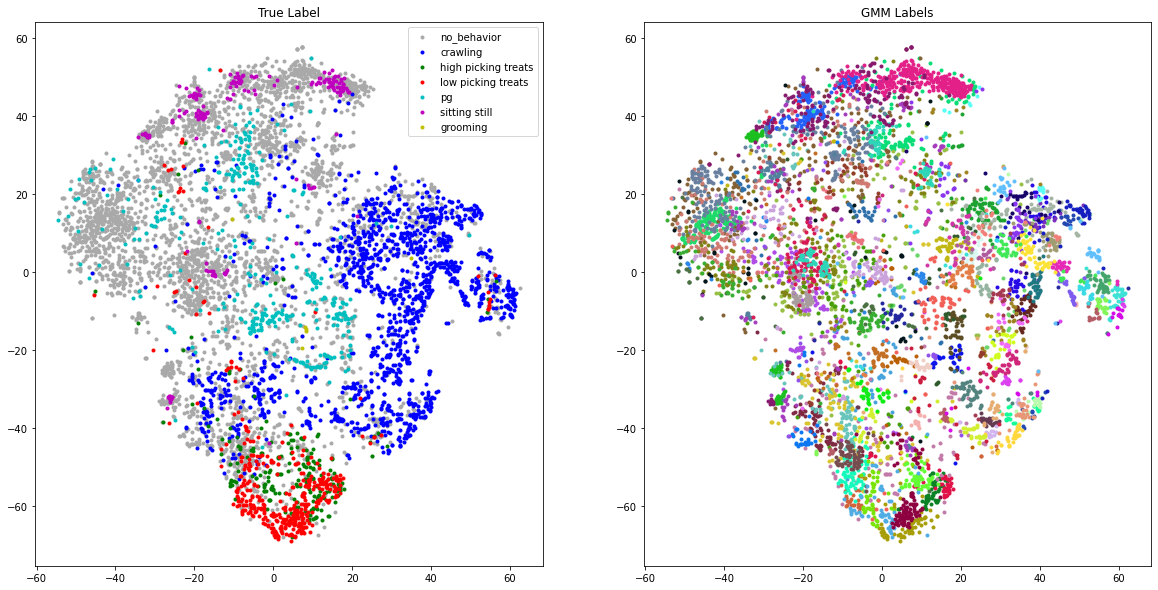

In [50]:
compare_label_tSNE(z_run, y_all, inv_bhvs, None, 'True Label', gmm_labels, None, hex_colors, 'GMM Labels',
                       one_in = 4, perplexity=80, n_iter=3000)

In [164]:
X_all_ = X_all[::2, :,:]
y_all_ = y_all[::2, :]
gmm_labels_ = gmm_labels[::2, :]

In [165]:
loc = ((y_all_ == bhvs['low picking treats']) + (y_all_ == bhvs['high picking treats'])).flatten()
print(sum(loc))
average_value = np.mean(X_all_[loc, :, :], axis=0)

1214


In [166]:
loc2 = (gmm_labels_ == 8).flatten()
print(sum(loc2))
average_value2 = np.mean(X_all_[loc2, :, :], axis=0)

1041


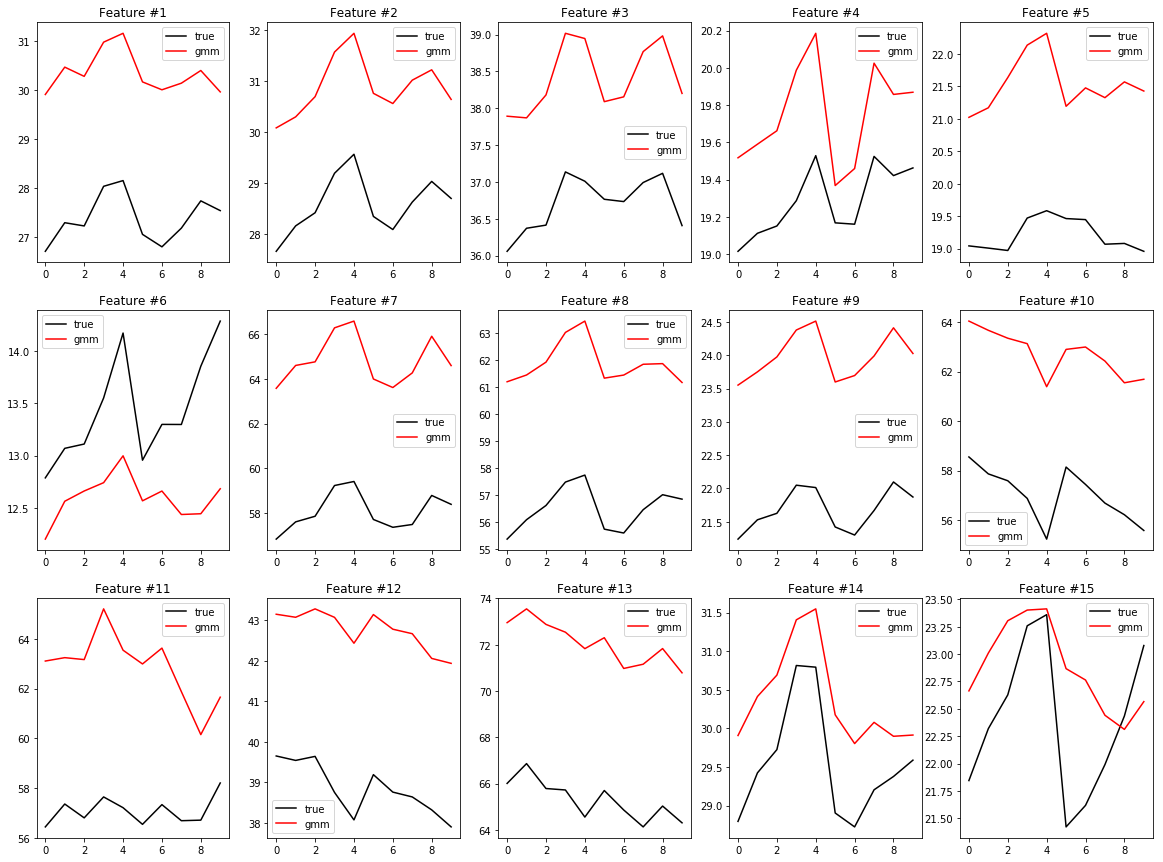

In [167]:
fig, axs = plt.subplots(3, 5, figsize = (20, 15))
for ii in range(15):
    ori = average_value[:, ii]
    rec = average_value2[:, ii]
    axs[ii//5, ii%5].plot(ori, color = 'black', label = 'true')
    axs[ii//5, ii%5].plot(rec, color = 'red', label = 'gmm')
    axs[ii//5, ii%5].set_title(f'Feature #{ii+1}')
    axs[ii//5, ii%5].legend()
# fig.suptitle(f'Ori and gmm of sequesce # {idx+1}', size = 20)
# plt.legend()
plt.show()

### Plot confusion matrix

In [32]:
gmm_labels.shape, y_all.shape

((25184, 1), (25184, 1))

In [33]:
label1 = y_all
label2 = gmm_labels

In [34]:
n1 = np.unique(label1).shape[0]
n2 = np.unique(label2).shape[0]
confusion = np.zeros((n1, n2))

In [35]:
for ii in range(n1):
    class1 = np.unique(label1)[ii]
    for jj in range(n2):
        class2 = np.unique(label2)[jj]
        nn = sum(np.logical_and((label1 == class1), (label2 == class2)))[0]
        confusion[ii, jj] = nn

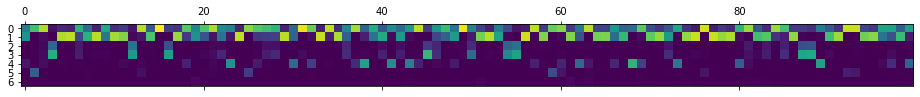

In [36]:
confusion_prob = confusion / np.sum(confusion, axis=0)
plt.matshow(confusion_prob[:, :])

[Text(1, 0.5, 'no_behavior'),
 Text(1, 1.5, 'crawling'),
 Text(1, 2.5, 'high picking treats'),
 Text(1, 3.5, 'low picking treats'),
 Text(1, 4.5, 'pg'),
 Text(1, 5.5, 'sitting still'),
 Text(1, 6.5, 'grooming')]

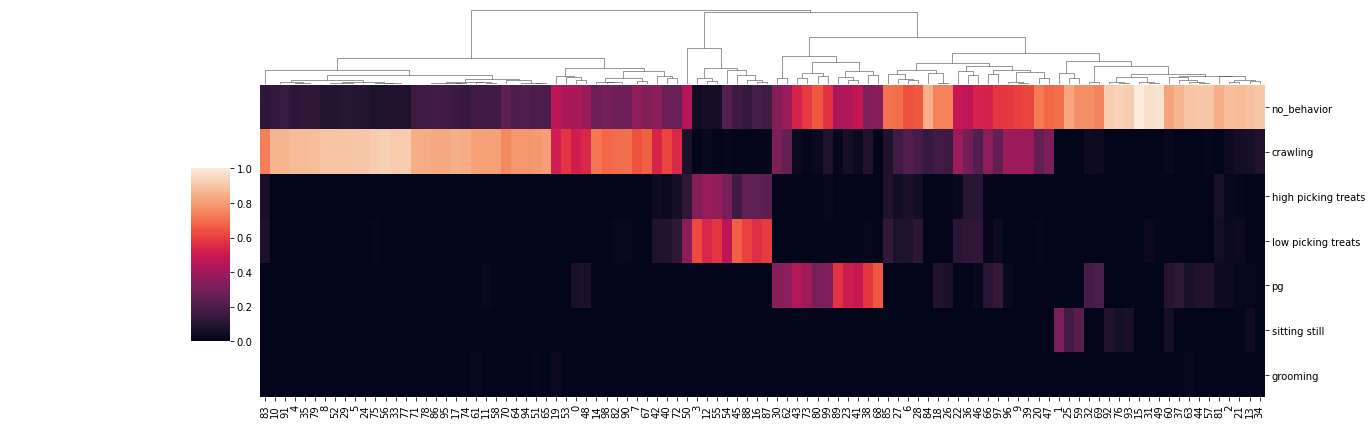

In [38]:
ax = clustermap(confusion_prob, row_cluster=False, xticklabels=1, figsize=(18,6))
ax.ax_cbar.set_position((0.15, .2, .03, .4))
ax.ax_heatmap.set_yticklabels(bhvs.keys(), rotation=0)

In [146]:
for ii in ax.ax_heatmap.get_xticklabels():
    print(ii.get_text())

16
13
71
26
31
43
72
60
25
45
88
99
77
19
9
59
18
49
89
57
48
75
80
38
81
27
6
61
69
83
20
35
56
34
51
66
14
73
44
96
10
76
93
30
64
0
2
33
15
58
46
90
85
12
62
36
87
8
52
39
47
4
55
41
74
3
63
67
98
5
29
84
1
94
97
79
95
11
42
53
17
22
37
86
21
68
24
65
7
70
92
82
91
23
32
54
78
40
28
50


### Raw data

In [ ]:
all_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                 '20201020_Pop_Cage_005','20201020_Pop_Cage_006','20201020_Pop_Cage_007']
X_all, y_all = load_data(direc = 'data', dataset="EMG", all_file = all_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
all_dataset = TensorDataset(torch.from_numpy(X_all))

In [52]:
X_all_cat = X_all.reshape(X_all.shape[0], -1)

In [128]:
gm_raw = GaussianMixture(n_components=100, random_state=111, max_iter=1000).fit_predict(X_all_cat)
gmm_raw_labels = np.reshape(gm_raw, (gm_raw.shape[0], 1))

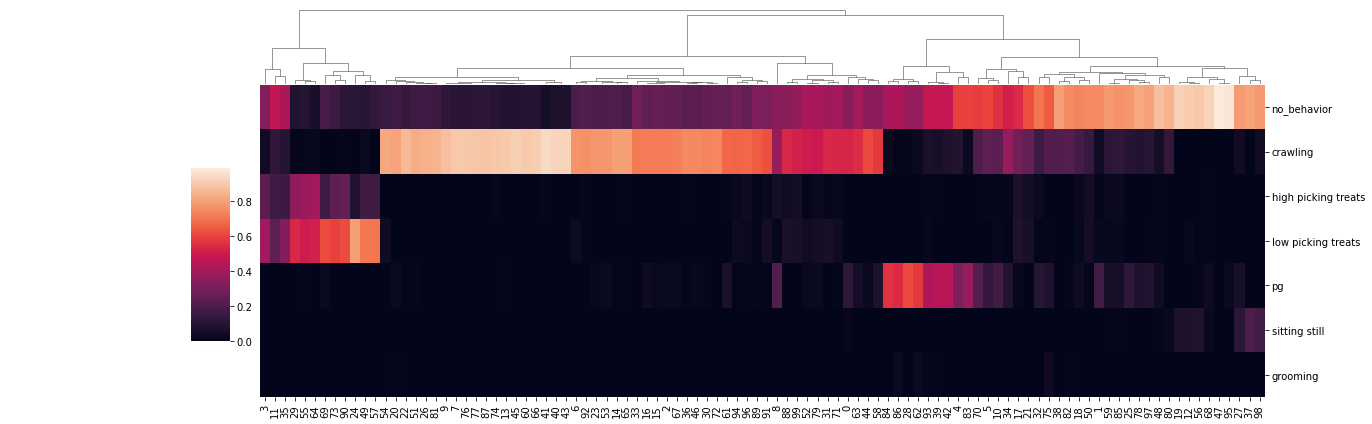

In [129]:
plot_confusion_matrix(y_all, gmm_raw_labels, bhvs.keys(), figsize = (18,6))

In [134]:
km_raw = KMeans(n_clusters=100, random_state=111, max_iter=1000).fit_predict(X_all_cat)
km_raw_labels = np.reshape(km_raw, (km_raw.shape[0], 1))

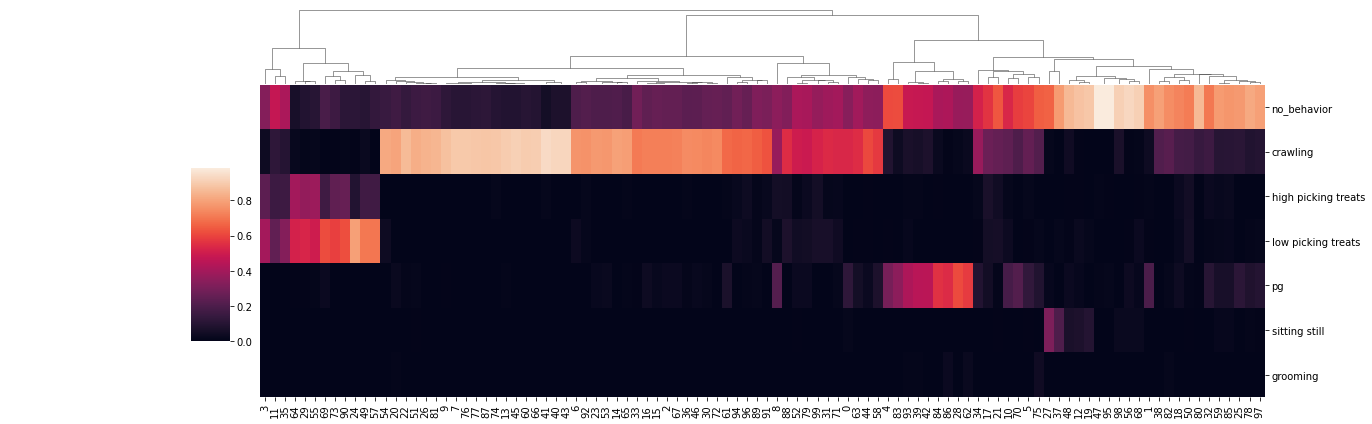

In [135]:
plot_confusion_matrix(y_all, km_raw_labels, bhvs.keys(), figsize = (18,6))

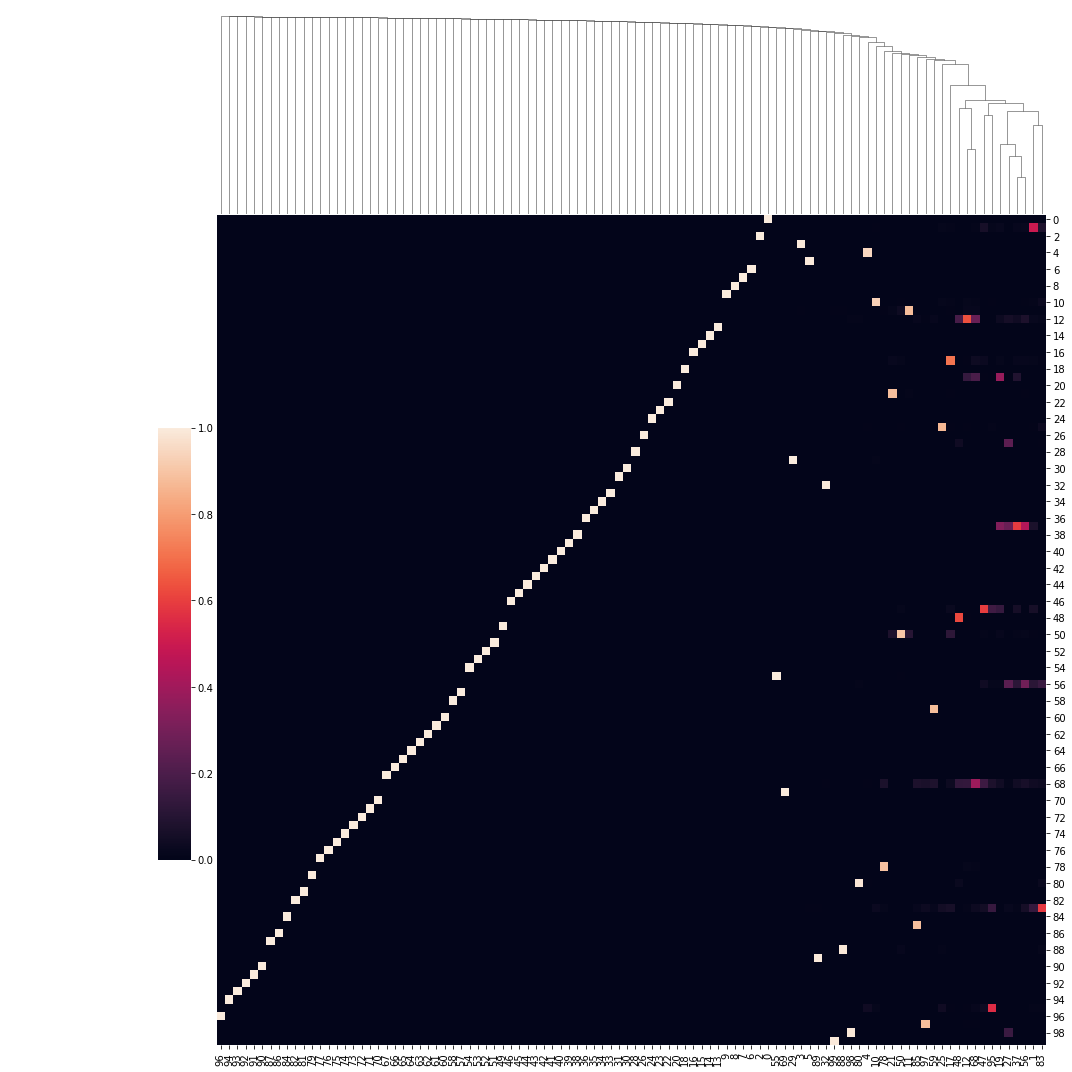

In [136]:
plot_confusion_matrix(gmm_raw_labels, km_raw_labels, None, figsize = (15, 15))

### pca

In [64]:
all_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                 '20201020_Pop_Cage_005','20201020_Pop_Cage_006','20201020_Pop_Cage_007']
X_all_pca, y_all, _, _ = load_data(direc = 'data', dataset="EMG", all_file = all_file,
                         do_pca = True, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
# all_dataset = TensorDataset(torch.from_numpy(X_all))

Loading 20201020_Pop_Cage_001, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_002, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_003, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_004, X shape (3601, 150, 1), y shape (3601, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_005, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  5.]
Loading 20201020_Pop_Cage_006, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_007, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Doing PCA
Explained variance ratio: [0.71996949 0.8243373  0.8835433  0.92542724 0.9445839  0.95903007
 0.9711758  0.97832234 0.98366708 0.98790915 0.99156346 0.99450025
 0.99662963 0.99850377 1.        ]
Dataset shape: (25184, 10, 6)
Lab

In [65]:
X_all_pca_cat = X_all_pca.reshape(X_all_pca.shape[0], -1)

In [137]:
gm_pca = GaussianMixture(n_components=100, random_state=111, max_iter=1000).fit_predict(X_all_pca_cat)
gmm_pca_labels = np.reshape(gm_pca, (gm_pca.shape[0], 1))

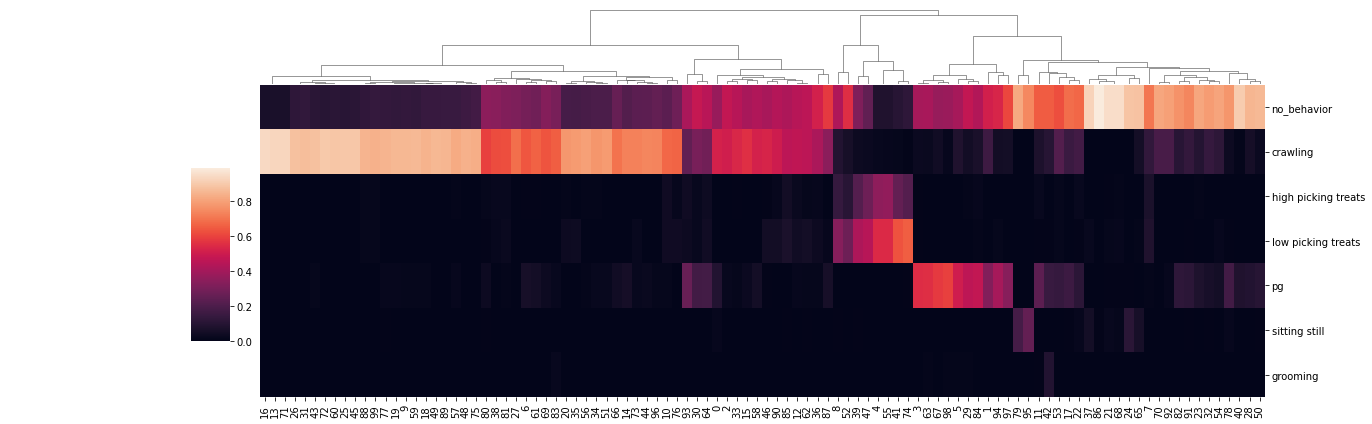

In [138]:
plot_confusion_matrix(y_all, gmm_pca_labels, bhvs.keys(), figsize = (18,6))

In [139]:
km_pca = KMeans(n_clusters=100, random_state=111, max_iter=1000).fit_predict(X_all_pca_cat)
km_pca_labels = np.reshape(km_pca, (km_pca.shape[0], 1))

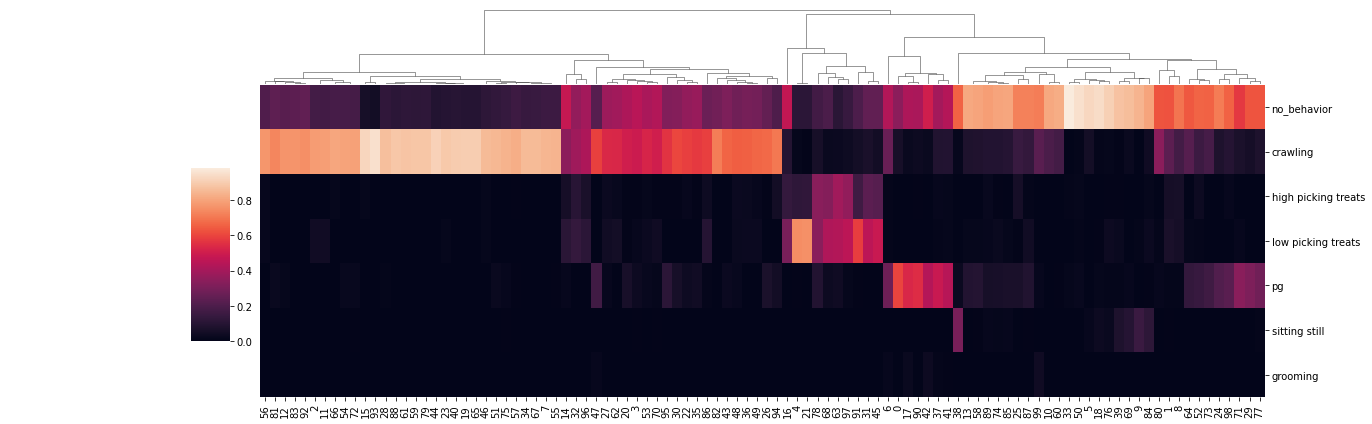

In [140]:
plot_confusion_matrix(y_all, km_pca_labels, bhvs.keys(), figsize = (18,6))

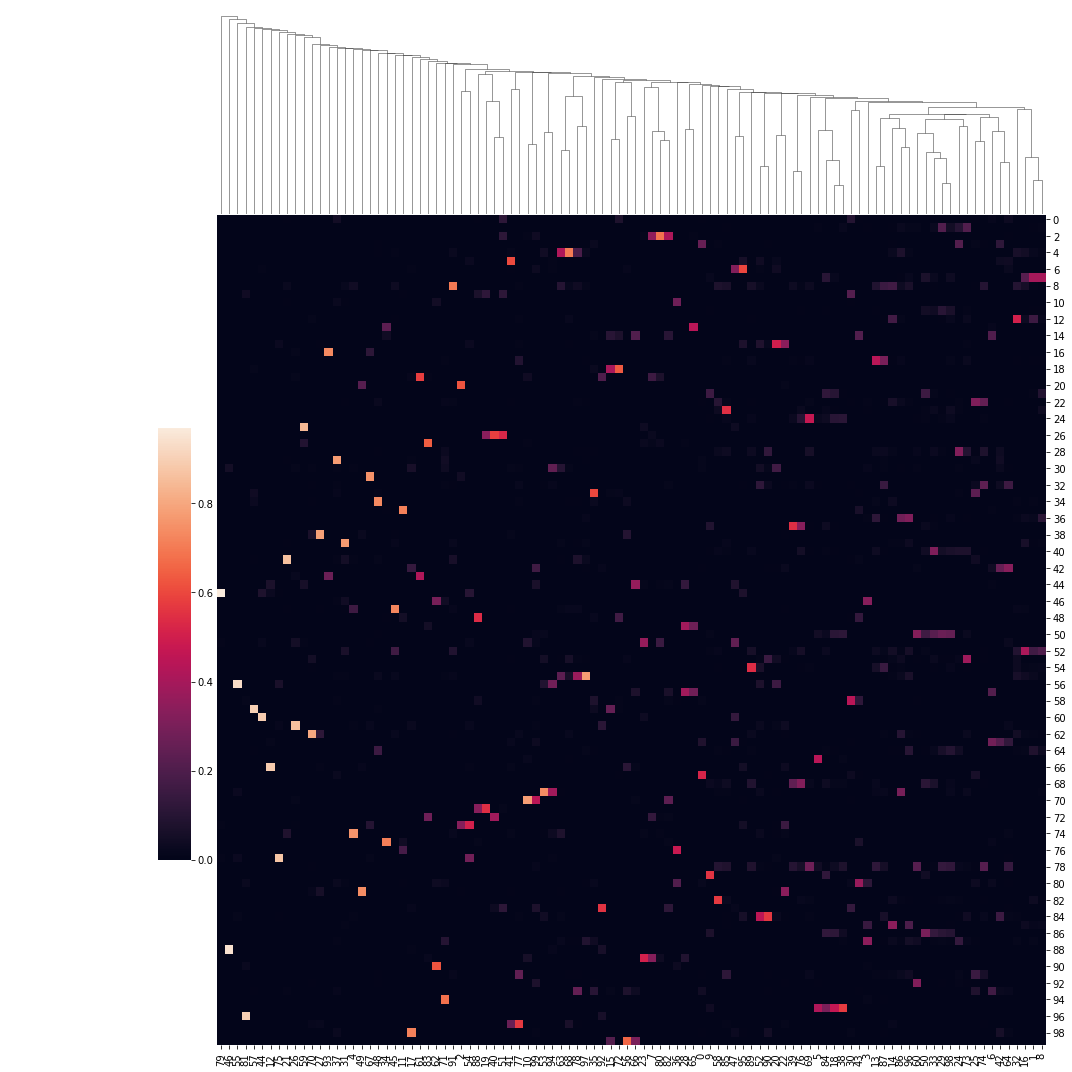

In [141]:
plot_confusion_matrix(gmm_pca_labels, km_pca_labels, None, figsize = (15, 15))

In [148]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

print(adjusted_mutual_info_score(gm, gm_pca))
print(adjusted_mutual_info_score(gm, gm_raw))
print(adjusted_mutual_info_score(gm_pca, gm_raw))

0.547580966965186
0.5369509810209463
0.64216936115087


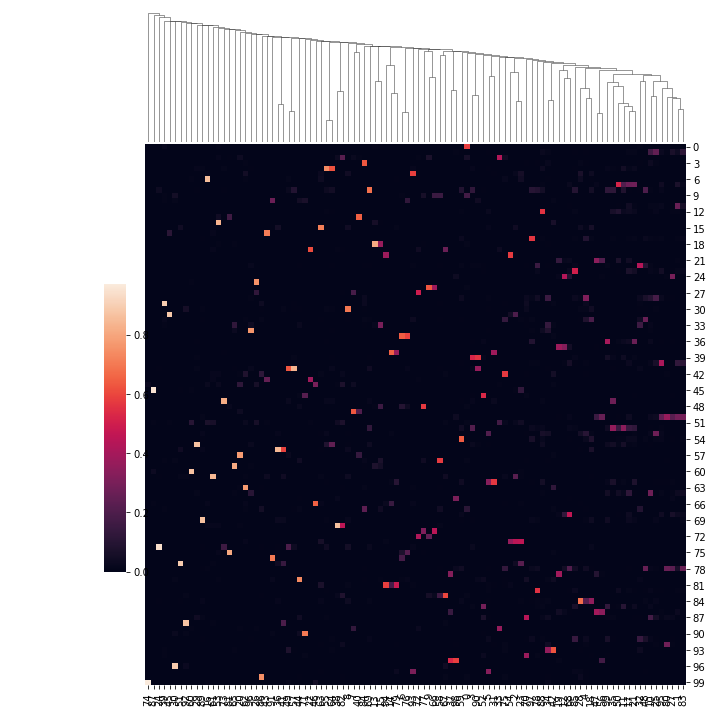

In [143]:
plot_confusion_matrix(gmm_pca_labels, gmm_raw_labels, None, figsize = (10, 10))

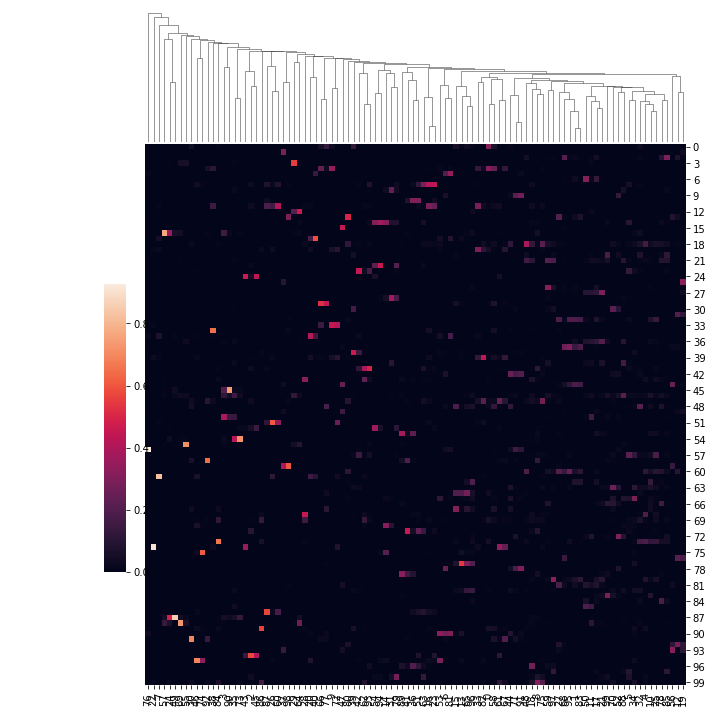

In [144]:
plot_confusion_matrix(gmm_labels, gmm_raw_labels, None, figsize = (10, 10))

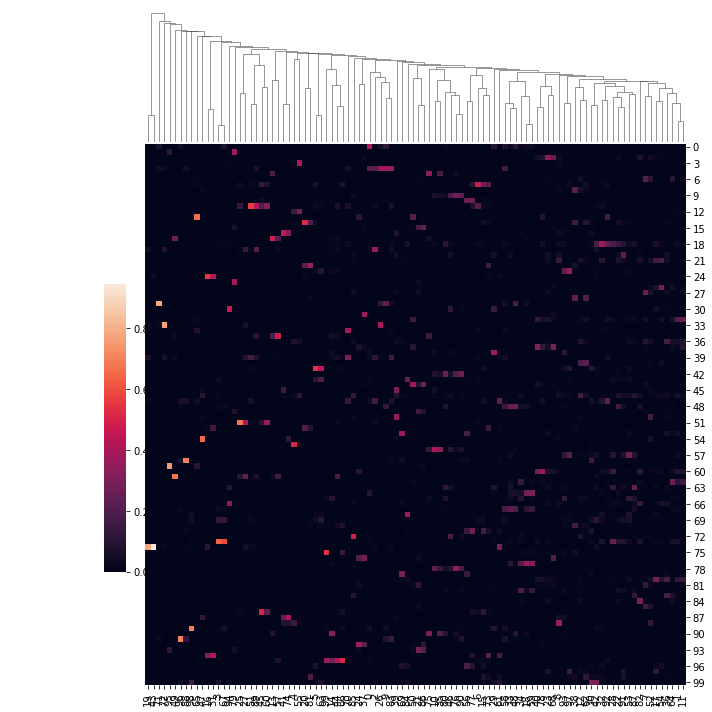

In [145]:
plot_confusion_matrix(gmm_labels, gmm_pca_labels, None, figsize = (10, 10))

In [125]:
from collections import Counter

unique, counts = np.unique(y_all, return_counts=True)
aaaa = dict(zip(unique, counts))
for key in aaaa.keys():
    print(f'{inv_bhvs[int(key)]}: {aaaa[key]}')

no_behavior: 14414
crawling: 6034
high picking treats: 846
low picking treats: 1582
pg: 1546
sitting still: 740
grooming: 22
